# Movie Recommender system

### Installing the required Libraries

In [8]:
#!pip install datasketch
#!pip install seaborn

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

### Loading the Data

In [61]:
movies_metadata = pd.read_csv('movies_metadata.csv')
keywords = pd.read_csv('keywords.csv')
credits = pd.read_csv('credits.csv')
links = pd.read_csv('links.csv')
links_small = pd.read_csv('links_small.csv')
ratings_small = pd.read_csv('ratings_small.csv')


In [62]:
# Check missing values
print("\nMissing Values:")
print("Movies Metadata:", movies_metadata.isnull().sum())



Missing Values:
Movies Metadata: adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64


In [63]:
print("Keywords:", keywords.isnull().sum())
print("Credits:", credits.isnull().sum())
print("Links:", links.isnull().sum())
print("Links Small:", links_small.isnull().sum())
print("Ratings Small:", ratings_small.isnull().sum())

Keywords: id          0
keywords    0
dtype: int64
Credits: cast    0
crew    0
id      0
dtype: int64
Links: movieId      0
imdbId       0
tmdbId     219
dtype: int64
Links Small: movieId     0
imdbId      0
tmdbId     13
dtype: int64
Ratings Small: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Handling with outliers has resulted in significant reduction of the data hence i have tried avoiding it

In [64]:
# # Handling missing values

# def is_integer(value):
#     try:
#         int(value)
#         return True
#     except ValueError:
#         return False

# # Apply the filter
# movies_metadata = movies_metadata[movies_metadata['id'].apply(is_integer)]
# movies_metadata['id'] = movies_metadata['id'].astype('int64')


# movies_metadata['genres'] = movies_metadata['genres'].fillna('Unknown')
# movies_metadata['production_companies'] = movies_metadata['production_companies'].fillna('Unknown')
# movies_metadata['production_countries'] = movies_metadata['production_countries'].fillna('Unknown')
# movies_metadata['budget'] = movies_metadata['budget'].fillna(movies_metadata['budget'].median())
# movies_metadata['revenue'] = movies_metadata['revenue'].fillna(movies_metadata['revenue'].median())

# # Handling outliers
# # Remove outliers in 'budget' and 'revenue' columns using IQR
# Q1 = movies_metadata['budget'].quantile(0.25)
# Q3 = movies_metadata['budget'].quantile(0.75)
# IQR = Q3 - Q1
# movies_metadata = movies_metadata[(movies_metadata['budget'] >= Q1 - 1.5 * IQR) & (movies_metadata['budget'] <= Q3 + 1.5 * IQR)]

# Q1 = movies_metadata['revenue'].quantile(0.25)
# Q3 = movies_metadata['revenue'].quantile(0.75)
# IQR = Q3 - Q1
# movies_metadata = movies_metadata[(movies_metadata['revenue'] >= Q1 - 1.5 * IQR) & (movies_metadata['revenue'] <= Q3 + 1.5 * IQR)]


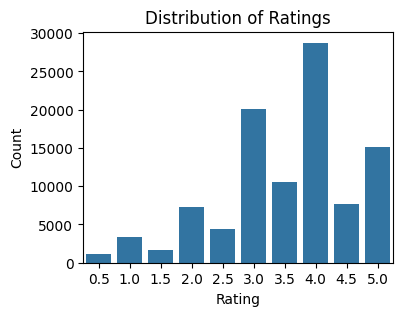

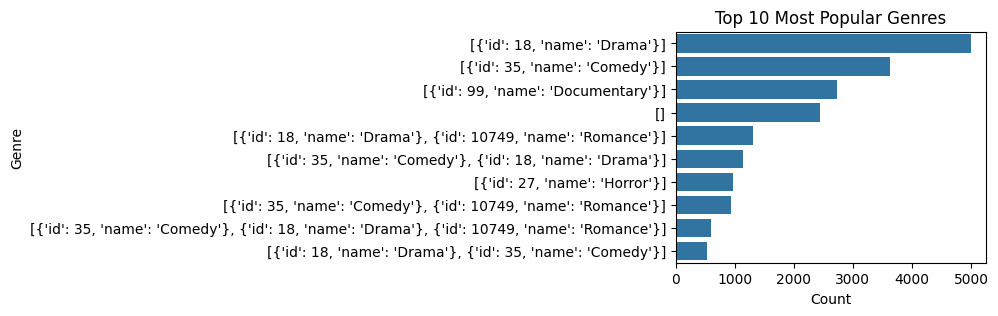

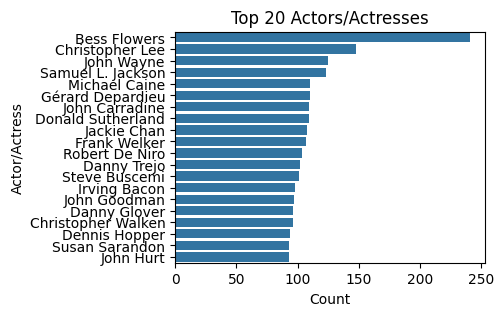

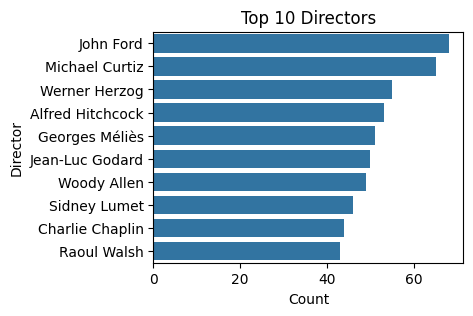

In [65]:
# Ratings Analysis
plt.figure(figsize=(4, 3))
sns.countplot(x='rating', data=ratings_small)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Genres Analysis
# Extract genres from the 'genres' column
genres_list = []
for genres in movies_metadata['genres']:
    if isinstance(genres, str):
        genres_list.extend(genres.split('|'))

# Create a DataFrame for genres
genres_df = pd.DataFrame({'genres': genres_list})

# Ploting the most popular genres
plt.figure(figsize=(4, 3))
sns.countplot(y='genres', data=genres_df, order=genres_df['genres'].value_counts().index[:10])
plt.title('Top 10 Most Popular Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

# Credits Analysis
# Extracting cast and crew information
credits['cast'] = credits['cast'].apply(lambda x: [actor['name'] for actor in eval(x)])
credits['crew'] = credits['crew'].apply(lambda x: [crew['name'] for crew in eval(x) if crew['job'] == 'Director'])

# Analyzing cast
cast_list = credits['cast'].explode().dropna()
plt.figure(figsize=(4, 3))
cast_count = cast_list.value_counts().head(20)
sns.barplot(x=cast_count.values, y=cast_count.index)
plt.title('Top 20 Actors/Actresses')
plt.xlabel('Count')
plt.ylabel('Actor/Actress')
plt.show()

# Analyzing directors
director_list = credits['crew'].explode().dropna()
plt.figure(figsize=(4, 3))
director_count = director_list.value_counts().head(10)
sns.barplot(x=director_count.values, y=director_count.index)
plt.title('Top 10 Directors')
plt.xlabel('Count')
plt.ylabel('Director')
plt.show()


Here we are converting all the values in the id column into integers which were initially objects by applying a condition which checks whether the given id is valid or not

In [66]:
def is_integer(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

# Apply the filter
movies_metadata = movies_metadata[movies_metadata['id'].apply(is_integer)]
movies_metadata['id'] = movies_metadata['id'].astype('int64')

Now, We are merging the keywords with the main dataframe

In [67]:
df = keywords.merge(credits, on='id')
movies_metadata = movies_metadata.merge(df, on='id')

In [68]:
print(keywords['id'].dtype)
movies_metadata.head()

int64


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter]
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston]
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch]
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[Whitney Houston, Angela Bassett, Loretta Devi...",[Forest Whitaker]
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[Steve Martin, Diane Keaton, Martin Short, Kim...",[Charles Shyer]


Demographic Filtering
Before getting started with this

we need a metric to score or rate a movie
Calculate the score for every movie
Sort the scores and recommend the best rated movie to the users.

Here I will be using imdb rating formula
(v/(v+m) * R) + (m/(m+v) * C)

where,

v is the number of votes for the movie;\
m is the minimum votes required to be listed in the chart;\
R is the average rating of the movie; And\
C is the mean vote across the whole report

In [69]:
Vavg= movies_metadata['vote_average'].mean()
Vavg

5.6117278654770075

In [70]:
quant= movies_metadata['vote_count'].quantile(0.9)
quant

156.0

In [71]:
q_movies = movies_metadata.copy().loc[movies_metadata['vote_count'] >= quant]
q_movies.shape

(4680, 27)

In [72]:
def weighted_rating(x, m=quant, C=Vavg):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [73]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [74]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.447079
10357,Dilwale Dulhania Le Jayenge,661.0,9.1,8.433941
837,The Godfather,6024.0,8.5,8.427092
12541,The Dark Knight,12269.0,8.3,8.266248
2858,Fight Club,9678.0,8.3,8.257355
292,Pulp Fiction,8670.0,8.3,8.252485
522,Schindler's List,4436.0,8.3,8.208674
23818,Whiplash,4376.0,8.3,8.207465
5505,Spirited Away,3968.0,8.3,8.198310
2223,Life Is Beautiful,3643.0,8.3,8.189610


The above code was only an attempt to sort out the list of movies according to their popularity

In [75]:
movies_metadata['overview'].head(5)

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

The script below imports the TfidfVectorizer class from the sklearn.feature_extraction.text module.\
It initializes a TF-IDF Vectorizer object, specifying to remove English stop words.\
NaN values in the 'overview' column of the 'movies_metadata' DataFrame are replaced with empty strings.\
The TF-IDF matrix is constructed by fitting and transforming the 'overview' data.

In [76]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movies_metadata['overview'] = movies_metadata['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies_metadata['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(46628, 75827)

Usage of cosine similarity

In [77]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
# Example: Using a subset of the input data
subset_tfidf_matrix = tfidf_matrix[:5000]  # Using the first 5000 samples as a subset due to memory issues
cosine_sim = linear_kernel(subset_tfidf_matrix, subset_tfidf_matrix)


In [78]:
indices = pd.Series(movies_metadata.index, index=movies_metadata['title']).drop_duplicates()

Function to get the recommendations

In [79]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the 5 most similar movies (excluding the input movie itself)
    similar_movie_indices = [i[0] for i in sim_scores[1:6]]

    # Get the titles of the most similar movies
    similar_movie_titles = [movies_metadata['title'].iloc[i] for i in similar_movie_indices]

    return similar_movie_titles


### This is an early attempt to predict/recommend movies

In [80]:

movie = get_recommendations('Money Train')
for i in range(5):
    print(f"{i+1}. {movie[i]}")

1. Shakedown
2. Serpico
3. Code of Silence
4. Romeo Is Bleeding
5. Next of Kin


Improving the model by involving more features


In [81]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    try:
        movies_metadata[feature] = movies_metadata[feature].apply(literal_eval)
    except (SyntaxError, ValueError):
        # Handle cases where literal_eval fails
        movies_metadata[feature] = movies_metadata[feature].apply(lambda x: [])


In [82]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [83]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [84]:
movies_metadata['director'] =movies_metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:

   movies_metadata[feature] =movies_metadata[feature].apply(get_list)

In [85]:
movies_metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,[],NaN,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,[],NaN,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,[],NaN,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [86]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [87]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies_metadata[feature] = movies_metadata[feature].apply(clean_data)

An attempt to improve the model by joining keywords, Cast, Director and genres

In [88]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies_metadata['soup'] = movies_metadata.apply(create_soup, axis=1)

In [89]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies_metadata['soup'])

Usage of cosine similarity again

In [90]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [91]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies_metadata = movies_metadata.reset_index()
indices = pd.Series(movies_metadata.index, index=movies_metadata['title'])

### Enter the name of the movie in the cell below to get recommendations

In [92]:
get_recommendations('Iron Man 2', cosine_sim2)

['X-Men', 'X2', 'Avengers: Age of Ultron', 'Ant-Man', 'Max Steel']

# Movie Recommender Based On Collaborative filtering


In [93]:
movies_metadata = pd.read_csv('movies_metadata.csv')
keywords = pd.read_csv('keywords.csv')
credits = pd.read_csv('credits.csv')
links = pd.read_csv('links.csv')
links_small = pd.read_csv('links_small.csv')
ratings = pd.read_csv('ratings_small.csv')

In [94]:
print("Movies Metadata:")
print(movies_metadata.head())
print("\nRatings:")
print(ratings.head())

Movies Metadata:
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  t

Same as that done in content based model

In [95]:
def is_integer(value):
    try:
        int(value)
        return True
    except ValueError:
        return False

# Apply the filter
movies_metadata = movies_metadata[movies_metadata['id'].apply(is_integer)]
movies_metadata['id'] = movies_metadata['id'].astype('int64')

In [96]:
# Preprocess movies_metadata
# Drop irrelevant columns
movies_metadata = movies_metadata[['id', 'title', 'genres']]

# Preprocess ratings
# Drop irrelevant columns
ratings = ratings[['userId', 'movieId', 'rating']]

# Merge datasets
merged_data = pd.merge(ratings, movies_metadata, left_on='movieId', right_on='id')

# Display the first few rows of the merged dataset
print("\nMerged Data:")
print(merged_data.head())


Merged Data:
   userId  movieId  rating    id                           title  \
0       1     1371     2.5  1371                       Rocky III   
1       1     1405     1.0  1405                           Greed   
2       1     2105     4.0  2105                    American Pie   
3       1     2193     2.0  2193                        My Tutor   
4       1     2294     2.0  2294  Jay and Silent Bob Strike Back   

                                              genres  
0                      [{'id': 18, 'name': 'Drama'}]  
1  [{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...  
2  [{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...  
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  
4                     [{'id': 35, 'name': 'Comedy'}]  


The script first preprocesses the data by averaging duplicate ratings and pivoting the user-item matrix.\
Singular Value Decomposition (SVD) is applied to reduce the dimensionality of the user-item matrix.\


In [97]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

# Create a user-item matrix
# Assuming merged_data contains the original dataset
# Remove duplicates by taking the average rating for each user-item combination
merged_data_avg = merged_data.groupby(['userId', 'movieId'])['rating'].mean().reset_index()

# Now pivot the data
user_item_matrix = merged_data_avg.pivot(index='userId', columns='movieId', values='rating').fillna(0)
# Convert the user-item matrix to a sparse matrix
sparse_matrix = csr_matrix(user_item_matrix.values)

# Apply Singular Value Decomposition (SVD)
svd = TruncatedSVD(n_components=50)
matrix_svd = svd.fit_transform(sparse_matrix)

# Display the shape of the transformed matrix
print("Shape of the transformed matrix:", matrix_svd.shape)


Shape of the transformed matrix: (671, 50)


A k-Nearest Neighbors (kNN) model is trained using the transformed matrix.\
The get_similar_movies function takes a movie ID as input and returns the top 5 similar movies based on kNN.\
Finally, the script demonstrates how to use this function to get movie recommendations.

In [98]:
from sklearn.neighbors import NearestNeighbors

# Fit in kNN model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5, n_jobs=-1)
knn_model.fit(matrix_svd)

# Function to get movie recommendations based on kNN
def get_similar_movies(movie_id, matrix=matrix_svd, knn_model=knn_model):
    # Find the index of the movie in the user-item matrix
    movie_index = merged_data[merged_data['movieId'] == movie_id].index[0]
    # Get the features of the movie
    movie_features = matrix_svd[movie_index].reshape(1, -1)
    # Find k-nearest neighbors
    distances, indices = knn_model.kneighbors(movie_features, n_neighbors=6)
    # Exclude the input movie itself
    similar_movies_indices = indices.flatten()[1:]
    # Get the movie IDs of similar movies
    similar_movies_ids = user_item_matrix.columns[similar_movies_indices]
    # Get the titles of similar movies
    similar_movies_titles = movies_metadata[movies_metadata['id'].isin(similar_movies_ids)]['title']
    return similar_movies_titles




#Enter the movie id here to get recommendations
#as this model works on the ratings and reviews of the movies, please ensure that the movieid for which you are trying to find recommendations 
#for has its presence in raings_small 
movie_id = 2100 
similar_movies = get_similar_movies(movie_id)
print("Top 5 similar movies:")
for idx, movie_title in enumerate(similar_movies):
    print(f"{idx + 1}.{movie_title}")


Top 5 similar movies:
1.Natural Born Killers
2.Judgment Night
3.Austin Powers: International Man of Mystery
4.The Crime of Padre Amaro
5.Bullitt
